In [2]:
import numpy as np
import scipy as sp
from sympy import inverse_fourier_transform, cos, exp, sqrt, pi
from sympy.abc import x, k

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.linalg import expm

from timeit import default_timer as timer
import pickle

In [3]:
# lattice vectors for fluorapatite crystal lattice (hexagonal)
# All units are in angstroms
#'Comodi P', 'Liu Y', 'Zanazzi P F', 'Montagnoli M', Structural and vibrational behaviour of fluorapatite with pressure., Part 1: in situ single-crystal X-ray diffraction investigation Sample: P = .0001 GPa


a = 9.375*np.array([1, 0 , 0])
b = 9.375*np.array([np.cos(120*np.pi/180), np.sin(120*np.pi/180), 0])
c = 6.887*np.array([0,0,1])

In [4]:
# these are in the crystal coordinate axes, so [x,y,z] == x*a + y*b + z*c
def to_real_space(vec):
    return a*vec[0] + b*vec[1] + c*vec[2]


# 2 fluorine sites in a unit cell
f_cell = np.array([ [0,0,1/4], [0,0,3/4] ])

f_space = np.array([to_real_space(atom) for atom in f_cell])

# 6 phosphorus sites in a unit cell. These came from the literature
#Old data from JM Hughes 1989
# New data - Comodi et. al. 2001
d1 = .36853
d2 = .39785

p_cell = np.array([[d1, d2, .25], [-d2, d1 - d2, .25], [d2 - d1, -d1, .25],
                   [-d1,-d2, .75], [d2, d2 - d1, .75], [d1-d2, d1, .75]])


def shift(cell, shift_vec):
    # cell is a unit cell of atoms (reduced coord)
    # shift_vec is a vector of integers
    # simple wrapper which takes a collection of reduced coordinate
    # vectors and returns the real space vectors, with an arbitrary shift
    # by a lattice vector
    #
    # Useful for tiling a unit cell and producing a larger crystal array
    
    return np.array([to_real_space(atom + shift_vec) for atom in cell])


f_space = np.concatenate(
            (
                shift(f_cell, [0,0,0]), shift(f_cell, [1,0,0]), shift(f_cell, [0,1,0]),
                shift(f_cell, [-1,0,0]), shift(f_cell, [0,-1,0]), shift(f_cell, [1,1,0]),
                shift(f_cell, [1,-1,0]), shift(f_cell, [-1,-1,0]), shift(f_cell, [-1,1,0])
            ),
    axis=0)


p_space = np.concatenate(
            (
                shift(p_cell, [0,0,0]), shift(p_cell, [1,0,0]), shift(p_cell, [0,1,0]),
                shift(p_cell, [-1,0,0]), shift(p_cell, [0,-1,0]), shift(p_cell, [1,1,0]),
                shift(p_cell, [1,-1,0]), shift(p_cell, [-1,-1,0]), shift(p_cell, [-1,1,0])
            ),
    axis=0)

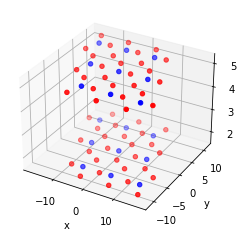

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(f_space.transpose()[0],f_space.transpose()[1],f_space.transpose()[2], c='b', marker='o')
ax.scatter(p_space.transpose()[0],p_space.transpose()[1],p_space.transpose()[2], c='r', marker='o')
plt.xlabel("x")
plt.ylabel("y")

plt.show()

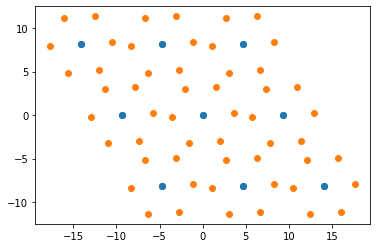

In [6]:
# sanity check, xy axis projection
plt.scatter(f_space.transpose()[0],f_space.transpose()[1])
plt.scatter(p_space.transpose()[0],p_space.transpose()[1])
plt.show()

In [7]:
p_space_3d =  np.concatenate(
            (
                shift(p_cell, [0,0,0]), shift(p_cell, [1,0,0]), shift(p_cell, [0,1,0]),
                shift(p_cell, [-1,0,0]), shift(p_cell, [0,-1,0]), shift(p_cell, [1,1,0]),
                shift(p_cell, [1,-1,0]), shift(p_cell, [-1,-1,0]), shift(p_cell, [-1,1,0]),
                
                shift(p_cell, [0,0,1]), shift(p_cell, [1,0,1]), shift(p_cell, [0,1,1]),
                shift(p_cell, [-1,0,1]), shift(p_cell, [0,-1,1]), shift(p_cell, [1,1,1]),
                shift(p_cell, [1,-1,1]), shift(p_cell, [-1,-1,1]), shift(p_cell, [-1,1,1]),
                
                shift(p_cell, [0,0,-1]), shift(p_cell, [1,0,-1]), shift(p_cell, [0,1,-1]),
                shift(p_cell, [-1,0,-1]), shift(p_cell, [0,-1,-1]), shift(p_cell, [1,1,-1]),
                shift(p_cell, [1,-1,-1]), shift(p_cell, [-1,-1,-1]), shift(p_cell, [-1,1,-1])
            ),
    axis=0)

origin = .25*c
num_phos = len(p_space_3d)


In [8]:
gammaF = 251.662*10**6 # rad/s/T
gammaP = 108.291*10**6
B = 7.1 # T
hbar = 1.05457*10**(-34) # J s / rad

dxF = .5*6.878*10**(-10) # m
dxP = np.linalg.norm(to_real_space(p_cell[0])-to_real_space(p_cell[1]))*10**-10 # m
dxFP = np.linalg.norm(to_real_space([0,0,.25])-to_real_space(p_cell[1]))*10**-10

mu0 = 4*np.pi*10**-7

omegaF = gammaF*B*10**-6/(2*np.pi)

In [9]:
omegaF # MHz

284.3780841475872

In [10]:
JF = (10**-7) * hbar * gammaF * gammaF * (1-3*np.cos(0)**2) / dxF **3

In [11]:
JF  # rad/s

-32843.10192611753

In [12]:
JP = (10**-7) * hbar * gammaP * gammaP * (1-3*np.cos(np.pi/2)**2) / dxP**3

In [13]:
JP  # rad/s

509.9971240503594

In [14]:
JFP = (10**-7) * hbar * gammaF * gammaP * (1-3*np.cos(np.pi/2)**2) / dxFP**3

In [15]:
JFP # rad/s

6158.49919020732

In [16]:
def fp_coupling(f_loc, p_loc):
    # compute J_{ij}^{FP} for fluorine spin at `f_loc`, and
    # phosphorus spin at `p_loc`, both in units of angstroms
    # coupling returned in units of rad/s
    r = (p_loc-f_loc)*10**-10
    dx = np.linalg.norm(r)
    rhat = r/dx
    cos = rhat[2]
    return (10**-7) * hbar * gammaF * gammaP * (1-3*cos**2) / dx**3

def make_fp_dict(origin, crystal):
    d= dict()
    for spin in crystal:
        d[spin.tobytes()] = fp_coupling(origin, spin)
    return d
fp_dict = make_fp_dict(to_real_space([0,0,.25]), p_space_3d)

In [17]:
def get_rand_config(n_spin,s=2):
    # get a random configuration of n_spins
    # each with spin-dimension s, so spin-1/2 is s=2,
    # spin-2 is s=5, etc (j=(s-1)/2)
    return rng.integers(low=0, high=s, size=n_spin)-(s-1)/2
    

def mean_field_calc(origin, crystal, config):
    # calculate mean field at `origin` given spin locations defined
    # in `crystal`, each with orientation defined by `config`
    gammaF = 251.662*10**6 # rad/s/T
    gammaP = 108.291*10**6
    hbar = 1.05457*10**(-34) # J s / rad
    return sum([fp_dict[spin.tobytes()]*orien for spin, orien in zip(crystal, config)])

rng = np.random.default_rng(8008502139)

In [18]:
def variance_estimate(origin, crystal, s=2):
    return ((s**2-1)/12)*sum([fp_dict[spin.tobytes()]**2 for spin in crystal])

In [19]:
def fourth_moment_est(origin, crystal, s=2):
    cross_contr = 3*variance_estimate(origin, crystal, s)**2
    coeff = 3*((s**2-1)/12)**2 - (s**2-1)*(3*s**2-7)/(16*15)
#     print(coeff)
    powsum = sum([fp_dict[spin.tobytes()]**4 for spin in crystal])
    return cross_contr - coeff*powsum

In [20]:
mean_field_calc(to_real_space([0,0,.25]), p_space_3d, get_rand_config(num_phos))

-2053.301744697511

In [21]:
v = variance_estimate(to_real_space([0,0,.25]), p_space_3d)
print(v)
print(v**0.5)

33732409.40677483
5807.960864776452


In [22]:
v4 = fourth_moment_est(to_real_space([0,0,.25]), p_space_3d)
print(v4*10**-15)
print(v4**0.25)

2.8711818052907323
7320.068974763627


In [23]:
kurtosis = v4/v**2
print(kurtosis)

2.5232830354638196


In [23]:
#BSSN distribution - (Hassan 2016):
ku = kurtosis
print(ku)
r= ((12*ku-36) + ((12*ku-36)**2 + 4*(12-4*ku) * (9*ku-15))**0.5)/(2*(12-4*ku)) #negative root gives bimodality!
phi = (2*r+3)/(2*v*(2*r+1))
delta= r/phi
print(phi)
print(delta)
print(r)
l = (4*r**2+12*r +5)/((2*r+3)**2)
print(3*l)

def bssn(x):
    return (2*phi**1.5)/((1+2*phi*delta)*np.pi**0.5)*(delta + x**2)*np.exp(-phi*x**2)

x= np.linspace(-20000, 20000, 1000)

2.5232830354638205
2.4647943028075915e-08
40919993.97084183
1.0085936801025195
2.5232830354638205


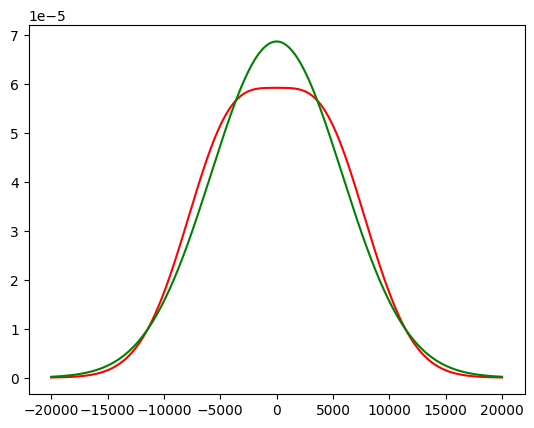

In [24]:
def gauss(x):
    return np.exp(-0.5*x**2/v)/(2*v*np.pi)**0.5
plt.plot(x, bssn(x), color='red')
plt.plot(x, gauss(x), color='green')

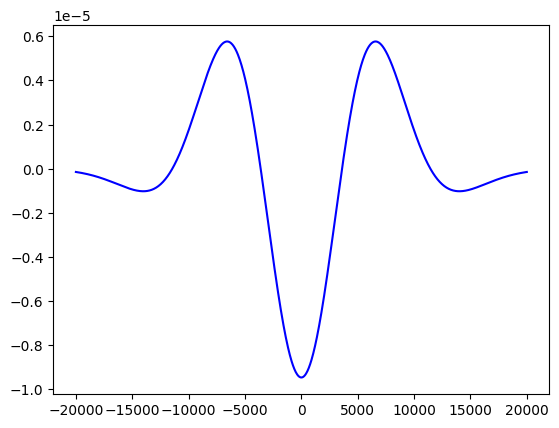

In [25]:
plt.plot(x, bssn(x)-gauss(x), color='blue')

In [26]:
def f(k, origin =to_real_space([0,0,.25]), crystal = p_space_3d):
    gammaF = 251.662*10**6 # rad/s/T
    gammaP = 108.291*10**6
    hbar = 1.05457*10**(-34) # J s / rad
    arr= [cos(fp_dict[spin.tobytes()]*k/2) for spin in crystal]
    val=1
    for a in arr:
        val*= a
    return val
print(f(0.0001))

0.842837785842122


In [27]:
# pdf_est = inverse_fourier_transform(f(k), k, x)
# print(pdf_est)


In [28]:
#fft estimation!
# mymax = 1.5*10**-3
# mystep = 10**-5
# N=10**4
# dx = 1
# a=[]
# # for t in np.arange(0, mymax + mystep, mystep):
# for t in range(0, N+1):
#     a.append(f(2*np.pi * t/(N*dx))/dx)
# for t in range(-N, 0):
#     a.append(f(2*np.pi * t/(N*dx))/dx)
# print(a)
    

In [29]:
# pos_pdf_est = np.fft.ifft(a)
# print(np.real(pos_pdf_est))
# #compute even extension how?
# plt.plot(np.real(pos_pdf_est[10:-10]))

In [30]:
try:
    FaP_distro = pickle.load(open("FaP_distro_1e6.dat", "rb"))
except (OSError, IOError) as e:
    start = timer()
    trials = 1000000
    FaP_distro = np.zeros(trials)
    for idx in range(trials):
        FaP_distro[idx] = mean_field_calc(to_real_space([0,0,.25]), p_space_3d, get_rand_config(num_phos))
    end = timer()
    print("computation time " + str(end-start))
    with open('FaP_distro_1e6.dat', 'wb') as fi:
        pickle.dump(FaP_distro, fi)


In [31]:
# start = timer()
# trials = 10000000
# FaP_distro = np.zeros(trials)
# for idx in range(trials):
#     FaP_distro[idx] = mean_field_calc(to_real_space([0,0,.25]), p_space_3d, get_rand_config(num_phos))
# end = timer()
# print("computation time " + str(end-start))
# with open('FaP_distro_1e6.dat', 'wb') as fi:
#     pickle.dump(FaP_distro, fi)

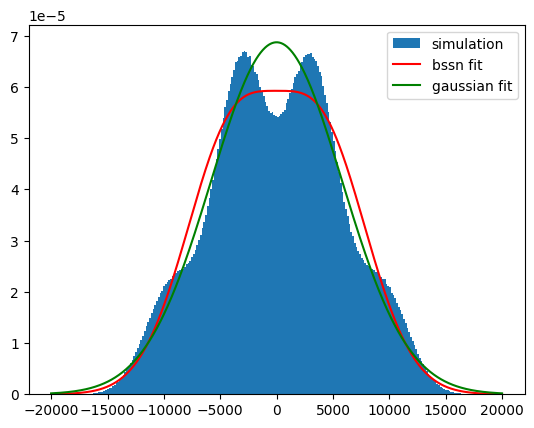

In [32]:
plt.hist(FaP_distro,bins=250,density=True, label ='simulation')
plt.plot(x, bssn(x), color='red', label = 'bssn fit')
plt.plot(x, gauss(x), color='green', label = 'gaussian fit')
leg = plt.legend()
plt.show()

In [33]:
np.average(FaP_distro)

2.2317856728297056

In [34]:
np.std(FaP_distro)

5808.257780279123